### Install PySpark

In [18]:
!pip install pyspark

### Create Spark Context

In [19]:
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import *
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.sql.functions import col

In [20]:
spark = SparkContext.getOrCreate()

### Load Dataset

In [21]:
spark.addFile('https://raw.githubusercontent.com/JonatasDeOliveira/movie-it/master/src/data/moviesOnStreamingPlatforms_updated.csv')

In [22]:
sql_context = SQLContext(spark)
movies_df = sql_context.read.csv(SparkFiles.get("moviesOnStreamingPlatforms_updated.csv"), header=True, inferSchema= True)

In [23]:
movies_df.show(20, False)

+---+---+----------------------------------+----+---+----+---------------+-------+----+-----------+-------+----+-------------------------------------------+----------------------------------------+-------------------------------------------+-------------------------------------------+-------+
|_c0|ID |Title                             |Year|Age|IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Type|Directors                                  |Genres                                  |Country                                    |Language                                   |Runtime|
+---+---+----------------------------------+----+---+----+---------------+-------+----+-----------+-------+----+-------------------------------------------+----------------------------------------+-------------------------------------------+-------------------------------------------+-------+
|0  |1  |Inception                         |2010|13+|8.8 |87%            |1      |0   |0          |0      |0   |Christ

In [24]:
movies_df.toPandas().isna().sum()

_c0                    0
ID                     0
Title                  0
Year                   0
Age                 9389
IMDb                 571
Rotten Tomatoes    11586
Netflix                1
Hulu                   0
Prime Video            0
Disney+                0
Type                   0
Directors            725
Genres               275
Country              435
Language             599
Runtime              592
dtype: int64

### Pre Processing Dataset 

In [25]:
movies_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Type: integer (nullable = true)
 |-- Directors: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Language: string (nullable = true)
 |-- Runtime: integer (nullable = true)



Pontos notados:

- Primeiramente, percebemos que temos duas colunas com "ids". Como pegamos esses dados do kaggle possivelmente esta primeira coluna não é necessária.
- Há uma coluna Type que possui somente valores iguais a 0. Procuramos entender o que seria mas não encontramos, vamos dropar essa coluna.
- Outra observação é que as colunas Directors, Genres, Country e Language são listas e estão como strings devemos processar também as mesmas.
- Colunas Age e Year estão como string, devem ser transformadas para integer.

In [26]:
from pyspark.sql.functions import split

In [27]:
movies_df_drop_c0 = movies_df.drop('_c0')

In [28]:
movies_df_drop_type = movies_df_drop_c0.drop('Type')

In [29]:
movies_df_split = (movies_df_drop_type.withColumn('DirectorsArray', split('Directors', ','))
.withColumn('GenresArray', split('Genres', ','))
.withColumn('CountriesArray', split('Country', ','))
.withColumn('LanguagesArray', split('Language', ','))
.drop('Directors')
.drop('Genres')
.drop('Country')
.drop('Language'))

In [30]:
# checando se todas as idades seguem o regex [0-9]+\+
df_filtered_age_pattern = movies_df_split.filter(col('Age').rlike('[0-9]+\+'))
df_filtered_age_pattern.count() == movies_df_split.count()

False

In [31]:
# verificar idades que não seguem o padrão
df_filtered_not_age_pattern = movies_df_split.filter(~col('Age').rlike('[0-9]+\+'))
df_filtered_not_age_pattern.show(5, False)

+---+-----------------------------------+----+---+----+---------------+-------+----+-----------+-------+-------+---------------------------+-----------------------------------------------------------------+----------------------------------------------------+----------------------------------+
|ID |Title                              |Year|Age|IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Runtime|DirectorsArray             |GenresArray                                                      |CountriesArray                                      |LanguagesArray                    |
+---+-----------------------------------+----+---+----+---------------+-------+----+-----------+-------+-------+---------------------------+-----------------------------------------------------------------+----------------------------------------------------+----------------------------------+
|55 |Willy Wonka & the Chocolate Factory|1971|all|7.8 |91%            |1      |0   |0          |0      |100    |[Me

In [32]:
# verficar que o padrão de idade em regex [0-9]+\+ unido a o padrão com 'all' contemplam todo o dataframe
df_filtered_pattern_all = movies_df_split.filter(col('Age').rlike('[0-9]+\+') | (col('Age') == 'all'))
movies_df_split.count() == df_filtered_pattern_all.count()

False

In [33]:
df_filtered_not_pattern_all = movies_df_split.filter(~(col('Age').rlike('[0-9]+\+') | (col('Age') == 'all')))
df_filtered_not_pattern_all.show(5, False)

+-----+-----------------------------+-------------------------+----+----+---------------+-------+----+-----------+-------+-------+--------------+-----------+--------------+--------------+
|ID   |Title                        |Year                     |Age |IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Runtime|DirectorsArray|GenresArray|CountriesArray|LanguagesArray|
+-----+-----------------------------+-------------------------+----+----+---------------+-------+----+-----------+-------+-------+--------------+-----------+--------------+--------------+
|15902|"""22"" A film about Veterans| Healthcare and Suicide."|2018|null|null           |null   |0   |0          |1      |null   |[0]           |null       |null          |null          |
+-----+-----------------------------+-------------------------+----+----+---------------+-------+----+-----------+-------+-------+--------------+-----------+--------------+--------------+



Claramente a linha apresentada acima é um erro pois a idade está como um ano, o ano está como um texto e a maioria das outras colunas estão vazias, vamos remover essa linha.

In [34]:
movies_df_filtered_age = movies_df_split.where(col('ID') != 15902)

Agora vamos processar Age para aparecer como um inteiro em todo dataframe. A idade (Age) possui dois formatos, a idade mínima pra assistir o filme acompanhada de um caracter '+' ou o texto escrito 'all'. Iremos seguir os seguintes passos:
- remover o caracter '+' das idades mínimas;
- tranformar todas linha com o valor 'all' para 0;
- transformar para um inteiro renomeando a coluna para MinimumAge;

In [35]:
movies_df_filtered_age.where(col('Age').isNull()).show()

+---+--------------------+----+----+----+---------------+-------+----+-----------+-------+-------+--------------------+--------------------+--------------------+--------------------+
| ID|               Title|Year| Age|IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Runtime|      DirectorsArray|         GenresArray|      CountriesArray|      LanguagesArray|
+---+--------------------+----+----+----+---------------+-------+----+-----------+-------+-------+--------------------+--------------------+--------------------+--------------------+
| 33|      Train to Busan|2016|null| 7.5|            94%|      1|   0|          1|      0|    118|      [Sang-ho Yeon]|[Action, Horror, ...|       [South Korea]|  [Korean, Hawaiian]|
| 58|      A Silent Voice|2016|null| 8.2|            94%|      1|   0|          0|      0|    130|      [Naoko Yamada]|[Animation, Drama...|             [Japan]|[Japanese, Japane...|
| 90|       The Dawn Wall|2018|null| 8.1|           100%|      1|   0|          0|   

In [36]:
from pyspark.sql.functions import translate
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

def transform_all_age_value(age):
  if age == 'all':
    return 0
  if age is None:
    return -1
  return int(age)

transformAllAgeValue = udf(lambda x: transform_all_age_value(x), IntegerType())

movies_df_age_processed = movies_df_filtered_age.withColumn("Age", translate('Age', '+', ''))
movies_df_classification = movies_df_age_processed.withColumn("MinimumClassification", transformAllAgeValue(col('Age'))).drop('Age')

Note que existe idade indicativa nula, setamos esses valores como -1.

In [37]:
movies_df_classification.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)



Analisando o schema novamente, podemos ver que assim como o campo Age, o campo Year deveria estar como Integer, vamos arrumar isso.

In [38]:
movies_df_year_processed = movies_df_classification.withColumn("Year", col("Year").cast(IntegerType()))

In [39]:
movies_df_year_processed.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)



Agora precisamos modificar a coluna Rotten Tomatoes para ser um integer.

In [40]:
movies_df_rotten_char = movies_df_year_processed.withColumn("RottenTomatoes", translate('Rotten Tomatoes', '%', '')).drop('Rotten Tomatoes')
movies_df_rotten_int = movies_df_rotten_char.withColumn("RottenTomatoes", col("RottenTomatoes").cast(IntegerType()))
movies_df_padronized_rotten = movies_df_rotten_int.withColumn("RottenTomatoes", col("RottenTomatoes") / 10)

In [41]:
movies_df_padronized_rotten.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)
 |-- RottenTomatoes: double (nullable = true)



In [42]:
movies_df_processed = movies_df_padronized_rotten

In [74]:
from pyspark.sql.functions import explode

movie_director_df = movies_df_processed.select('ID', 'DirectorsArray').withColumn('Director', explode(col('DirectorsArray'))).select('ID', 'Director')
movie_genre_df = movies_df_processed.select('ID', 'GenresArray').withColumn('Genre', explode(col('GenresArray'))).select('ID', 'Genre')
movie_country_df = movies_df_processed.select('ID', 'CountriesArray').withColumn('Country', explode(col('CountriesArray'))).select('ID', 'Country')
movie_language_df = movies_df_processed.select('ID', 'LanguagesArray').withColumn('Language', explode(col('LanguagesArray'))).select('ID', 'Language')

### Removing Outliers 

In [46]:
movies_df_pd = movies_df_processed.toPandas()

In [67]:
movies_df_pd.describe()

,ID,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,MinimumClassification,RottenTomatoes,runtime_log
count,16743.000000,16743.000000,16173.000000,16743.000000,16743.000000,16743.000000,16743.000000,16152.000000,16743.000000,5158.000000,16152.000000
mean,8372.050290,2003.013140,5.902751,0.212626,0.053933,0.737801,0.033686,93.413447,5.065520,6.542846,1.948431
std,4833.514844,20.674614,1.347867,0.409178,0.225892,0.439843,0.180424,28.219222,7.998182,2.661450,0.155808
min,1.000000,1902.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.200000,0.000000
25%,4186.500000,2000.000000,5.100000,0.000000,0.000000,0.000000,0.000000,82.000000,-1.000000,4.400000,1.913814
50%,8372.000000,2012.000000,6.100000,0.000000,0.000000,1.000000,0.000000,92.000000,-1.000000,7.100000,1.963788
75%,12557.500000,2016.000000,6.900000,0.000000,0.000000,1.000000,0.000000,104.000000,13.000000,8.800000,2.017033
max,16744.000000,2020.000000,9.300000,1.000000,1.000000,1.000000,1.000000,1256.000000,18.000000,10.000000,3.098990


Percebemos que as métricas do runtime estão um pouco estranhas o mínimo e o máximo estão muito distantes dos valores dos quartis, isso pode indicar que existem outliers. Analisando os quartis as durações dos filmes possuem valores esperados devido ao nosso conhecimento do problema (filmes), porém os mínimos e máximo tem valores muito díspares, o que indica que há outliers no dataset.

Vamos visualizar o runtime em forma de gráfico.

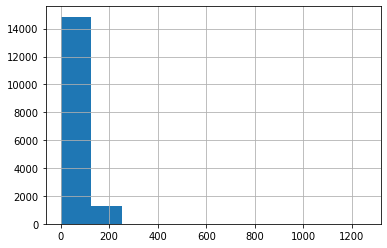

In [68]:
movies_df_pd['Runtime'].hist()

A distribuição de runtime dos filmes ficou ruim de ser visualizada no histograma possivelmente por causa de outliers. Iremos utiliza o log10 para visualizar melhor.

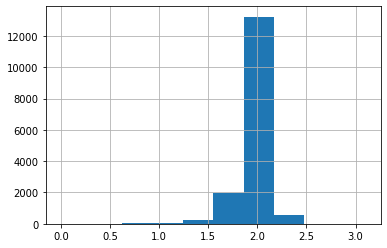

In [47]:
from numpy import log10
movies_df_pd['runtime_log'] = log10(movies_df_pd['Runtime'])
movies_df_pd['runtime_log'].hist()

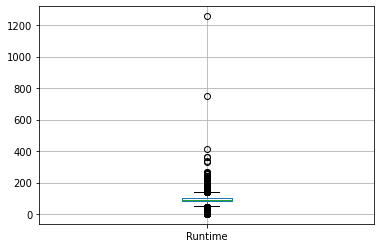

In [65]:
movies_df_pd.boxplot(column='Runtime')

Analisando o boxplot, fica claro que existem outliers. Vamos Fazer o processo de remoção utilizando o Z-Score Robusto (MAD). 

In [52]:
from numpy import abs
mad = abs(movies_df_pd['runtime_log'] - movies_df_pd['runtime_log'].median()).median()*(1/0.6745)
print(mad)

0.07409040023993868


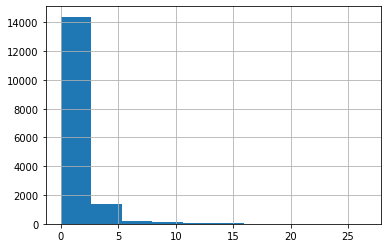

In [54]:
(abs(movies_df_pd['runtime_log']-movies_df_pd['runtime_log'].median())/mad).hist()

In [106]:
movies_df_mad = movies_df_pd[abs(movies_df_pd['runtime_log']-movies_df_pd['runtime_log'].median())/mad < 6]
movies_df_mad

,ID,Title,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,DirectorsArray,GenresArray,CountriesArray,LanguagesArray,MinimumClassification,RottenTomatoes,runtime_log
0,1,Inception,2010,8.8,1,0,0,0,148.0,[Christopher Nolan],"[Action, Adventure, Sci-Fi, Thriller]","[United States, United Kingdom]","[English, Japanese, French]",13,8.7,2.170262
1,2,The Matrix,1999,8.7,1,0,0,0,136.0,"[Lana Wachowski, Lilly Wachowski]","[Action, Sci-Fi]",[United States],[English],18,8.7,2.133539
2,3,Avengers: Infinity War,2018,8.5,1,0,0,0,149.0,"[Anthony Russo, Joe Russo]","[Action, Adventure, Sci-Fi]",[United States],[English],13,8.4,2.173186
3,4,Back to the Future,1985,8.5,1,0,0,0,116.0,[Robert Zemeckis],"[Adventure, Comedy, Sci-Fi]",[United States],[English],7,9.6,2.064458
4,5,"The Good, the Bad and the Ugly",1966,8.8,1,0,1,0,161.0,[Sergio Leone],[Western],"[Italy, Spain, West Germany]",[Italian],18,9.7,2.206826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16733,16735,Sultan And The Rock Star,1980,5.9,0,0,0,1,60.0,[Edward M. Abroms],"[Adventure, Drama, Family]",[United States],[English],-1,NaN,1.778151
16736,16738,The Bears and I,1974,6.2,0,0,0,1,89.0,[Bernard McEveety],"[Drama, Family]",[United States],[English],0,NaN,1.949390
16737,16739,Whispers: An Elephant's Tale,2000,5.0,0,0,0,1,72.0,[Dereck Joubert],"[Adventure, Family]",[United States],[English],0,NaN,1.857332
16738,16740,The Ghosts of Buxley Hall,1980,6.2,0,0,0,1,120.0,[Bruce Bilson],"[Comedy, Family, Fantasy, Horror]",[United States],[English],-1,NaN,2.079181


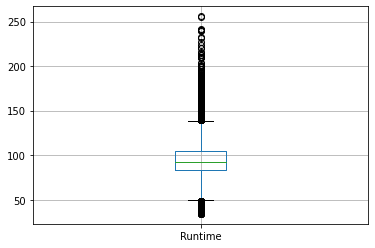

In [107]:
movies_df_mad.boxplot(column='Runtime')

In [108]:
movies_no_outliers = movies_df_mad

### Análises Descritivas

Iremos rodar a correlação de spearman sobre o dataset para verificar se há algum tipo de correlação entre as colunas.

Podemos perceber que há uma correlação alta e positiva entre as colunas RottenTomatoes e IMDb, que é esperado porque ambos representam a opinião sobre o filme.

In [111]:
movies_no_outliers.corr(method='spearman')

,ID,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,MinimumClassification,RottenTomatoes,runtime_log
ID,1.000000,-0.350017,-0.400934,-0.700863,-0.227470,0.546765,0.285726,-0.280196,-0.163700,-0.279249,-0.280196
Year,-0.350017,1.000000,-0.003990,0.360902,0.136674,-0.345340,-0.090826,0.070147,-0.030794,0.078947,0.070147
IMDb,-0.400934,-0.003990,1.000000,0.137611,0.035283,-0.162088,0.072997,0.141415,-0.072812,0.623921,0.141415
Netflix,-0.700863,0.360902,0.137611,1.000000,-0.106990,-0.749441,-0.086596,0.149845,0.048488,0.020196,0.149845
Hulu,-0.227470,0.136674,0.035283,-0.106990,1.000000,-0.264222,-0.034499,0.044053,0.099688,0.018185,0.044053
Prime Video,0.546765,-0.345340,-0.162088,-0.749441,-0.264222,1.000000,-0.302869,-0.117404,-0.090067,-0.045645,-0.117404
Disney+,0.285726,-0.090826,0.072997,-0.086596,-0.034499,-0.302869,1.000000,-0.007072,0.058737,-0.015780,-0.007072
Runtime,-0.280196,0.070147,0.141415,0.149845,0.044053,-0.117404,-0.007072,1.000000,0.146794,-0.011441,1.000000
MinimumClassification,-0.163700,-0.030794,-0.072812,0.048488,0.099688,-0.090067,0.058737,0.146794,1.000000,-0.211506,0.146794
RottenTomatoes,-0.279249,0.078947,0.623921,0.020196,0.018185,-0.045645,-0.015780,-0.011441,-0.211506,1.000000,-0.011441


Agora queremos analisar a quantidade de filmes por plataforma de streaming.

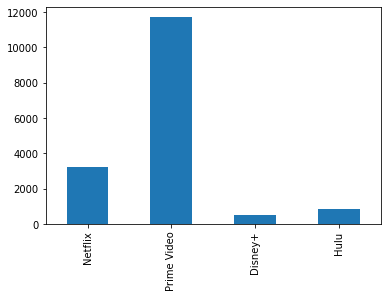

In [112]:
movies_no_outliers[['Netflix', 'Prime Video', 'Disney+', 'Hulu']].sum(skipna=True).plot.bar()

Agora vamos analisar a criação de filmes ao longo das décadas.

In [116]:
movies_no_outliers['decade'] = movies_no_outliers['Year'].floordiv(10) * 10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


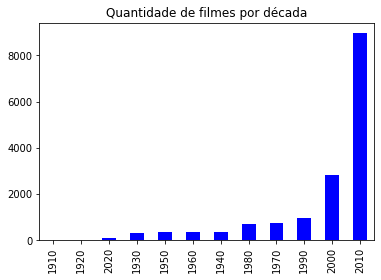

In [117]:
quantity_movies_by_sec = movies_df_mad['decade'].value_counts().sort_values()
quantity_movies_by_sec.plot.bar(color=(0,0,1), title='Quantidade de filmes por década')

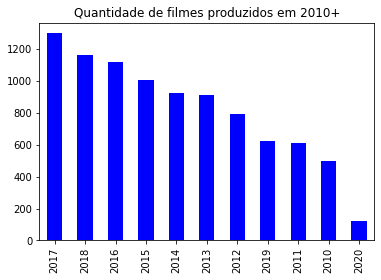

In [60]:
movies_df_2010 = movies_df_mad[movies_df_mad['Year'] >= 2010]
movies_df_2010 = movies_df_2010.sort_values(['Year'])
quantity_movies_2010 = movies_df_2010['Year'].value_counts()
quantity_movies_2010.plot.bar(color=(0,0,1), title='Quantidade de filmes produzidos em 2010+')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


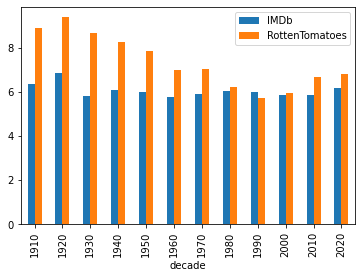

In [119]:
t = movies_df_mad.groupby('decade')['IMDb', 'RottenTomatoes'].mean()
t.plot.bar()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


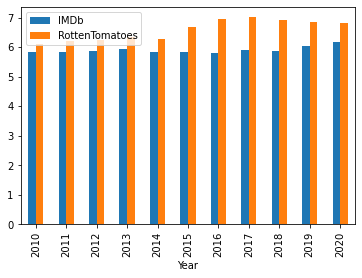

In [62]:
t = movies_df_2010.groupby('Year')['IMDb', 'RottenTomatoes'].mean()
t.plot.bar()

In [63]:
from pyspark.sql.functions import when,count

movies_df_aval = movies_df_processed.where(col('IMDb').isNotNull() & col('RottenTomatoes').isNotNull())

movies_df_aval.agg(
    count(when(col("IMDb") >= 9, True)).alias('IMDb Count'),
    count(when(col("RottenTomatoes") >= 9, True)).alias('RottenTomatoes Count')
).show()

+----------+--------------------+
|IMDb Count|RottenTomatoes Count|
+----------+--------------------+
|         1|                1126|
+----------+--------------------+



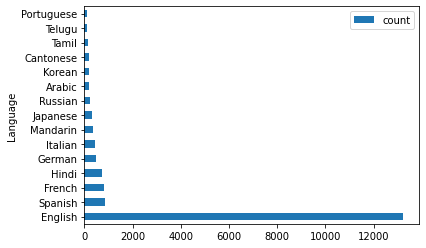

In [170]:
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import count

movies_count_by_language = movie_language_df.groupBy('Language').agg(countDistinct('ID').alias('count')).toPandas()
movies_count_by_language.nlargest(15, 'count').plot.barh(x='Language')

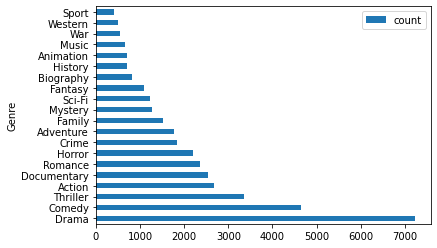

In [150]:
movies_count_by_genre = movie_genre_df.groupBy('Genre').agg(countDistinct('ID').alias('count')).toPandas()
movies_count_by_genre.nlargest(20, 'count').plot.barh(x='Genre')

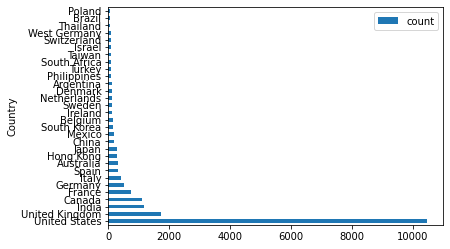

In [152]:
movies_count_by_country = movie_country_df.groupBy('Country').agg(countDistinct('ID').alias('count')).toPandas()
movies_count_by_country.nlargest(30, 'count').plot.barh(x='Country')

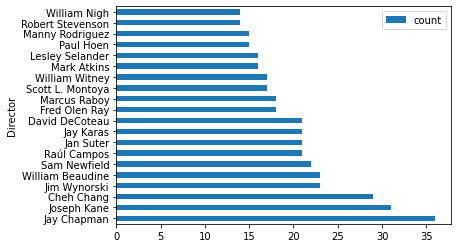

In [154]:
movies_count_by_directors = movie_director_df.groupBy('Director').agg(countDistinct('ID').alias('count')).toPandas()
movies_count_by_directors.nlargest(20, 'count').plot.barh(x='Director')

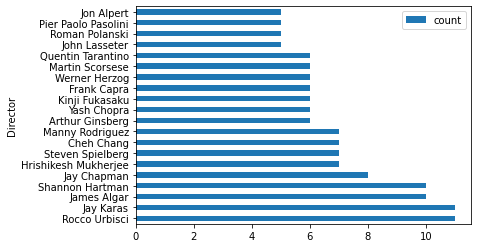

In [171]:
directors_high_grade_count = movie_director_df.distinct()\
                            .join(movies_df_processed, movies_df_processed['ID'] == movie_director_df['ID'])\
                            .select('Director', 'IMDb')\
                            .where(col('IMDb') > 7)\
                            .groupBy('Director')\
                            .agg(count('IMDb').alias('count')).toPandas()
directors_high_grade_count.nlargest(20, 'count').plot.barh(x='Director')

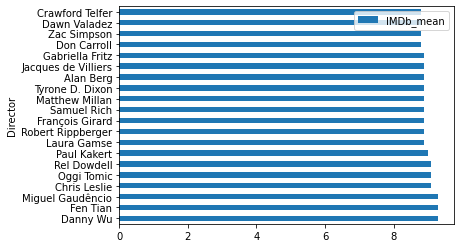

In [172]:
from pyspark.sql.functions import mean

directors_high_grade_mean = movie_director_df.distinct()\
                            .join(movies_df_processed, movies_df_processed['ID'] == movie_director_df['ID'])\
                            .select('Director', 'IMDb')\
                            .groupBy('Director')\
                            .agg(mean('IMDb').alias('IMDb_mean')).toPandas()
directors_high_grade_mean.nlargest(20, 'IMDb_mean').plot.barh(x='Director')

In [174]:
movie_director_df.distinct()\
.join(movies_df_processed, movies_df_processed['ID'] == movie_director_df['ID'])\
.select('Director', 'IMDb').where(col('Director') == 'Fen Tian').show()

+--------+----+
|Director|IMDb|
+--------+----+
|Fen Tian| 9.3|
+--------+----+



ANALISES
- Qual é mais critico em relacão as notas (imdb ou rotten)
- Quantidade de filmes presentes em cada plataforma
- Alguma relacao de ano + nota / nota + regiao produzida / nota + ator conhecido
- Agrupar por ator para ver qual ator fez mais filme, fazer uma analise do ator + media dos filmes que ele esteve presente
 
HIPOTESES
- Filmes de acao tem uma classificacao indicativa maior
- Filmes de drama / romance tem maior nota no rotten tomatoes
- Existe maior quantidade de filmes em ingles
- Existe maior quantidade de filmes feito nos USA